Index fixed to DatetimeIndex: DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09', '2024-01-10',
               ...
               '2025-01-26', '2025-01-27', '2025-01-28', '2025-01-29',
               '2025-01-30', '2025-01-31', '2025-02-01', '2025-02-02',
               '2025-02-03', '2025-02-04'],
              dtype='datetime64[ns]', length=401, freq='D')


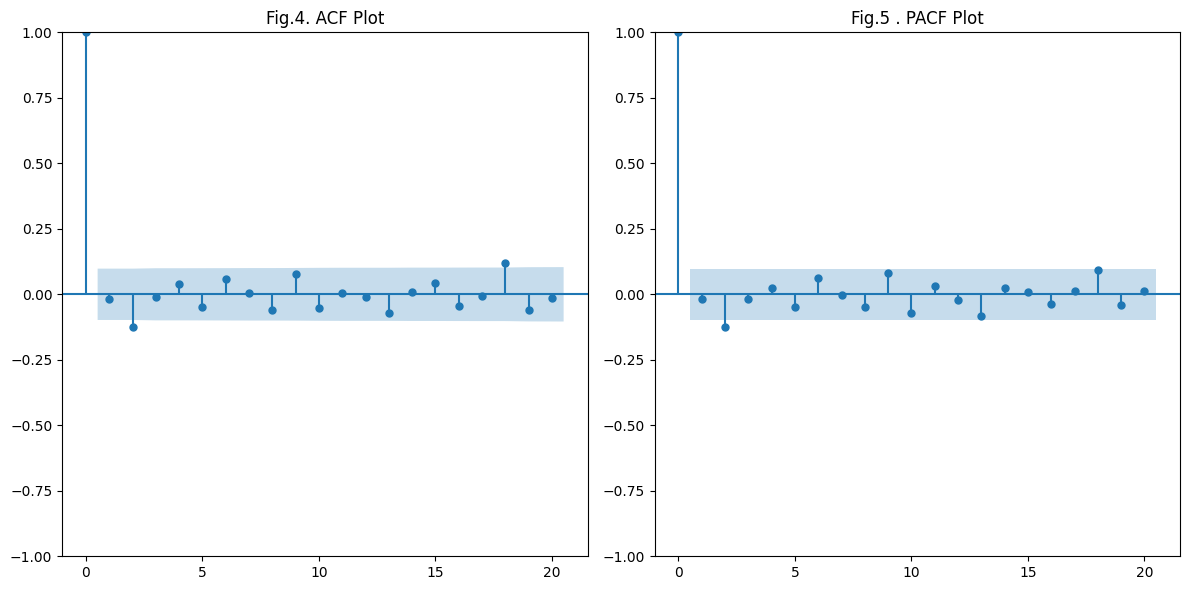

Best ARIMA Order: (1, 0, 2), AIC: 1837.8999052298009
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  401
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -914.950
Date:                Mon, 02 Dec 2024   AIC                           1837.900
Time:                        21:08:03   BIC                           1853.846
Sample:                    01-01-2024   HQIC                          1844.216
                         - 02-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0014      0.001   1159.657      0.000       1.000       1.003
ma.L1         -0.0208      0.036     -0.572      0.568      -0.092       0.051

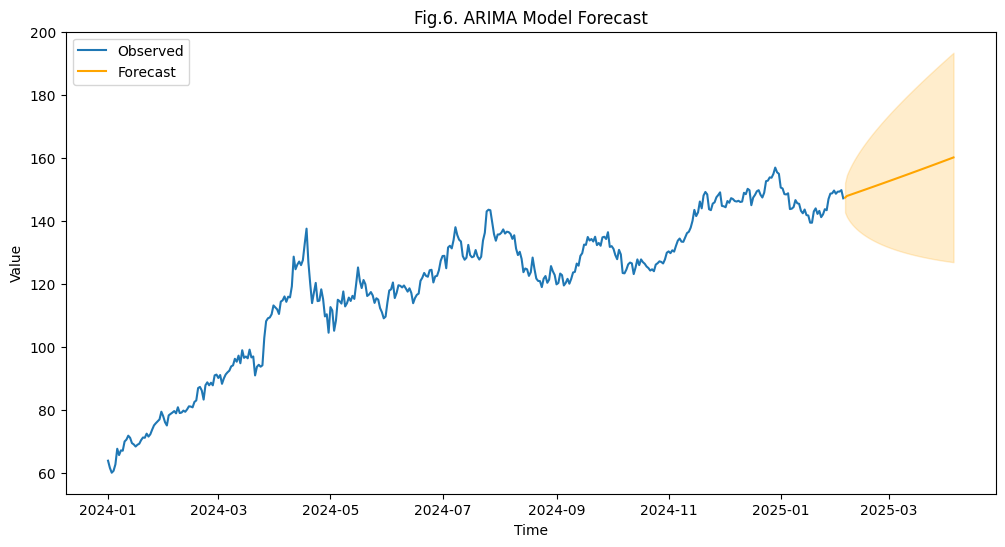

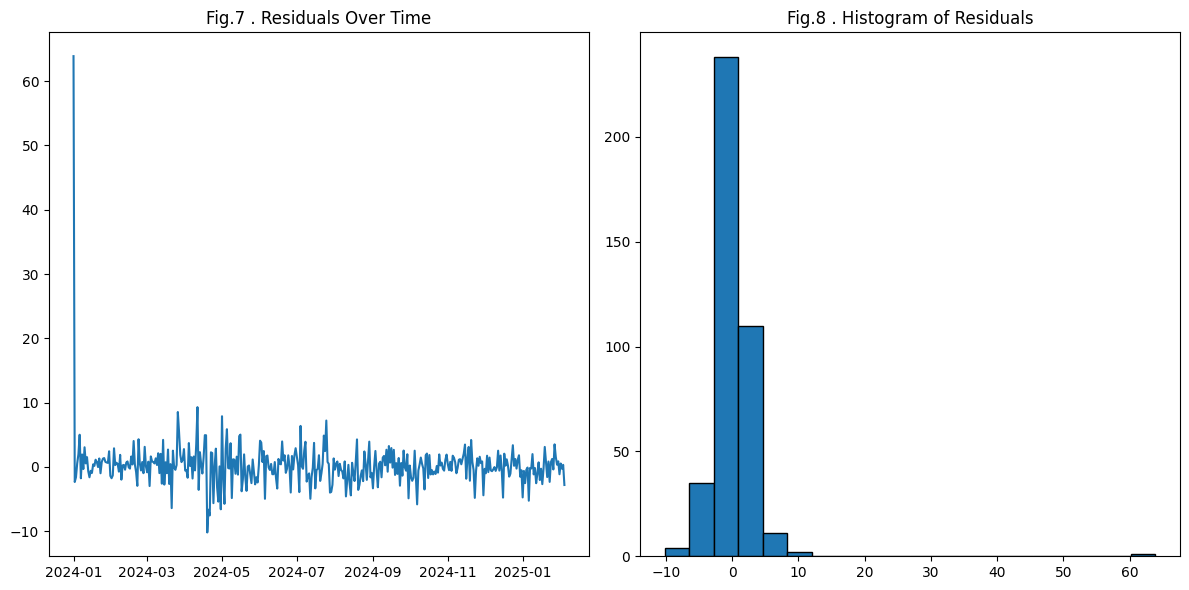

Mean of residuals: 0.21241020613156755
Variance of residuals: 15.925873418530966
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  401
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -922.174
Date:                Mon, 02 Dec 2024   AIC                           1850.347
Time:                        21:08:05   BIC                           1862.322
Sample:                    01-01-2024   HQIC                          1855.089
                         - 02-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5619      0.443      1.268      0.205      -0.307       1.430
ma.L1         -0.6102      0.429     -1.421      0

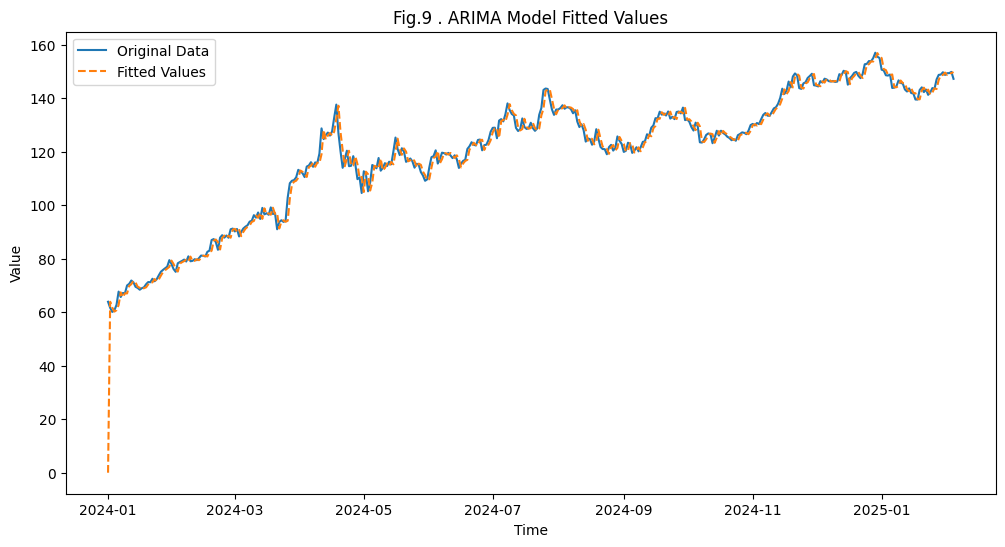

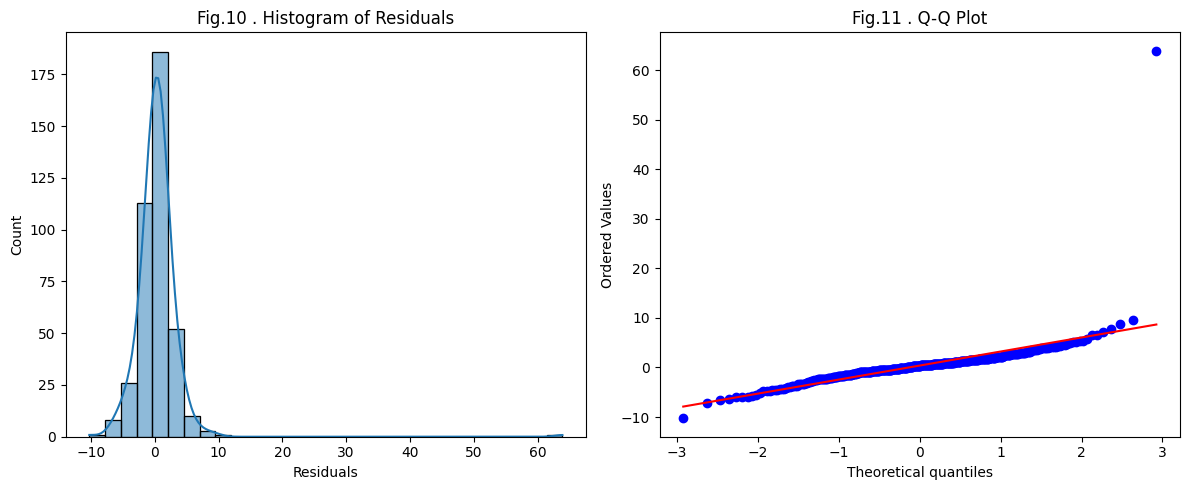

Shapiro-Wilk Test: W=0.5103, p-value=8.5203e-32


In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import itertools

# Load dataset
file_path = 'D:/Statistics/ts2.csv'  # Replace with actual file path
data_raw = pd.read_csv(file_path)
data = data_raw.rename(columns={"Unnamed: 0": "Time", "x": "Value"}).set_index("Time")

# Fix index to DatetimeIndex
data.index = pd.date_range(start='2024-01-01', periods=len(data), freq='D')  # Adjust as needed
print("Index fixed to DatetimeIndex:", data.index)

# Step 1: Differencing (if needed)
diff_data = data.diff().dropna()

# Step 2: Plot ACF and PACF to identify ARIMA parameters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(diff_data, lags=20, ax=plt.gca())
plt.title('Fig.4. ACF Plot')
plt.subplot(1, 2, 2)
plot_pacf(diff_data, lags=20, ax=plt.gca())
plt.title('Fig.5 . PACF Plot')
plt.tight_layout()
plt.show()

# Step 3: Define a function for ARIMA grid search
def grid_search_arima(data, p_values, d_values, q_values):
    best_aic = float('inf')
    best_order = None
    best_model = None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = SARIMAX(data, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
                best_model = results
        except Exception as e:
            continue
    return best_order, best_aic, best_model

# Step 4: Perform grid search to find optimal ARIMA parameters
p_values = range(0, 3)  # Adjust as needed
d_values = range(0, 1)  # Differencing order; typically 0 or 1
q_values = range(0, 3)  # Adjust as needed

best_order, best_aic, best_model = grid_search_arima(data['Value'], p_values, d_values, q_values)
print(f"Best ARIMA Order: {best_order}, AIC: {best_aic}")

# Step 5: Refit the model with best parameters
model = SARIMAX(data['Value'], order=best_order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())



# Step 6: Forecasting
forecast_steps = 60  # Adjust the number of steps to forecast
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Plot forecast
forecast_ci = forecast.conf_int()
plt.figure(figsize=(12, 6))
plt.plot(data['Value'], label='Observed')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='orange')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.2)
plt.title('Fig.6. ARIMA Model Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Step 7: Residual Diagnostics
residuals = results.resid

# Residual plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.title('Fig.7 . Residuals Over Time')
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Fig.8 . Histogram of Residuals')
plt.tight_layout()
plt.show()

# Residual statistics
print("Mean of residuals:", np.mean(residuals))
print("Variance of residuals:", np.var(residuals))

# Step 5: Fit an ARIMA model
p, d, q = 1, 1, 1  # Initial guess for ARIMA parameters
arima_model = ARIMA(data, order=(p, d, q))
arima_result = arima_model.fit()

# Print ARIMA model summary
print(arima_result.summary())

# Step 6: Plot original vs fitted values
data['Fitted'] = arima_result.fittedvalues

plt.figure(figsize=(12, 6))
plt.plot(data['Value'], label='Original Data')
plt.plot(data['Fitted'], label='Fitted Values', linestyle='--')
plt.title('Fig.9 . ARIMA Model Fitted Values')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Step 7: Residual analysis
residuals = arima_result.resid

# Residual histogram and Q-Q plot
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, bins=30)
plt.title('Fig.10 . Histogram of Residuals')
plt.xlabel('Residuals')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Fig.11 . Q-Q Plot')

plt.tight_layout()
plt.show()


# Shapiro-Wilk test for residual normality
shapiro_test = stats.shapiro(residuals)
print(f'Shapiro-Wilk Test: W={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4e}')




Index fixed to DatetimeIndex: DatetimeIndex(['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04',
               '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08',
               '2024-01-09', '2024-01-10',
               ...
               '2025-01-26', '2025-01-27', '2025-01-28', '2025-01-29',
               '2025-01-30', '2025-01-31', '2025-02-01', '2025-02-02',
               '2025-02-03', '2025-02-04'],
              dtype='datetime64[ns]', length=401, freq='D')


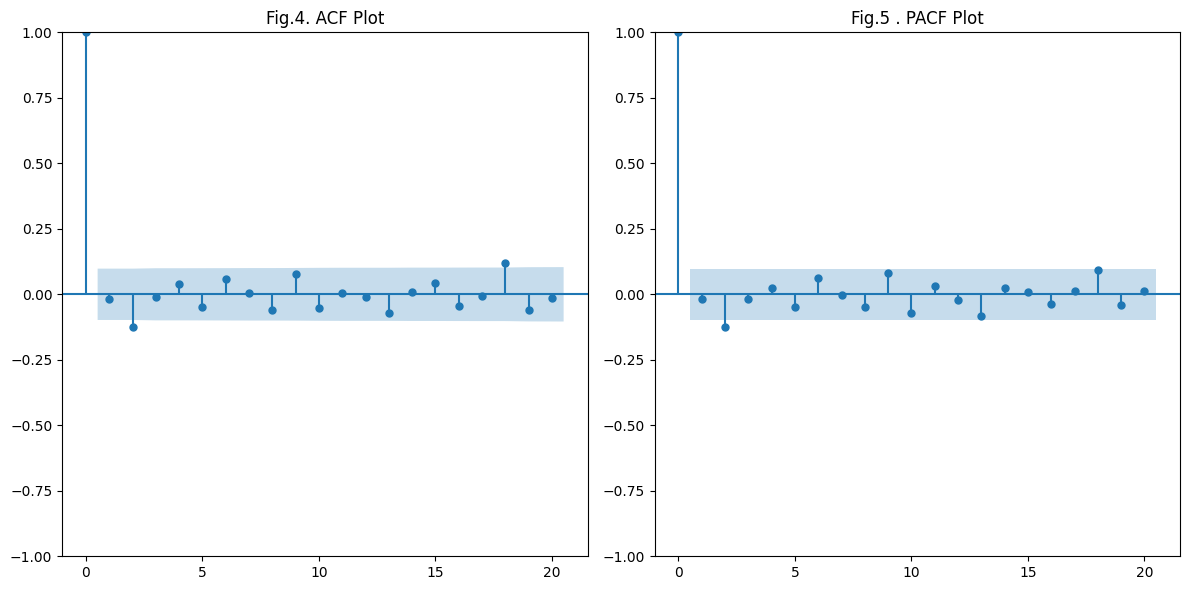

Best ARIMA Order: (1, 0, 2), AIC: 1837.8999052298009
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  401
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -914.950
Date:                Mon, 02 Dec 2024   AIC                           1837.900
Time:                        21:12:44   BIC                           1853.846
Sample:                    01-01-2024   HQIC                          1844.216
                         - 02-04-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0014      0.001   1159.657      0.000       1.000       1.003
ma.L1         -0.0208      0.036     -0.572      0.568      -0.092       0.051

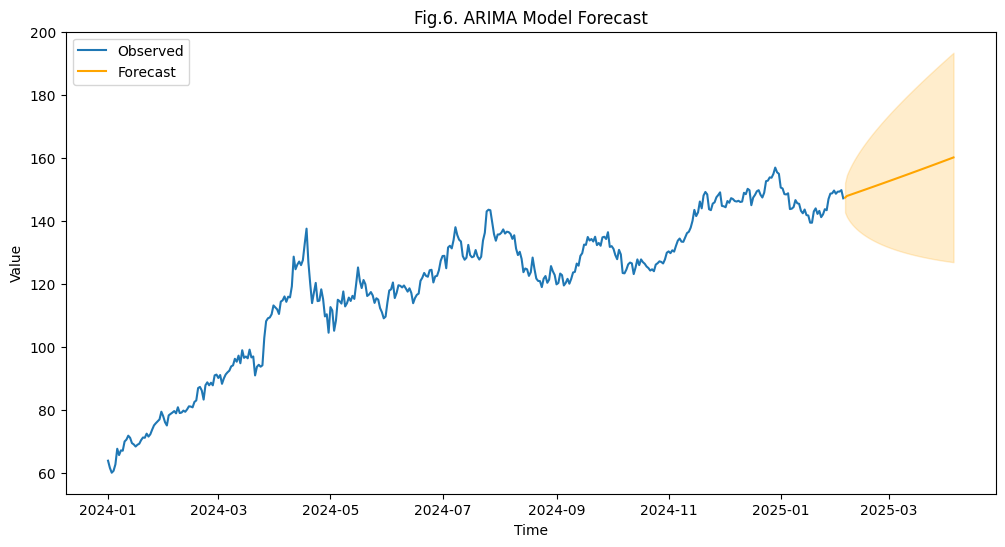

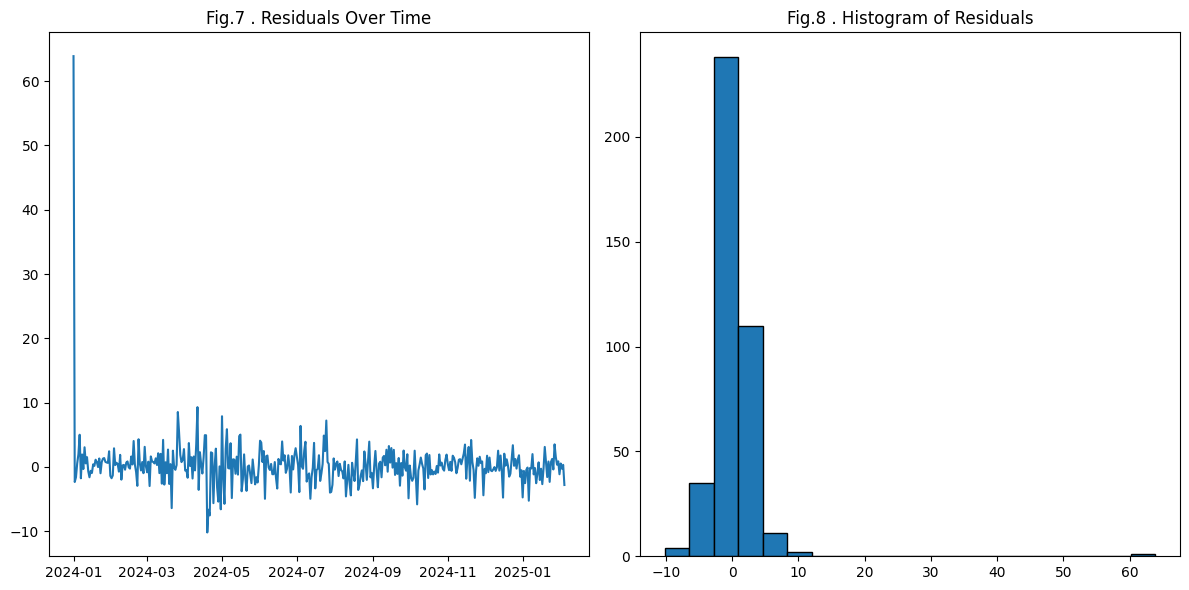

Mean of residuals: 0.21241020613156755
Variance of residuals: 15.925873418530966
Mean Squared Error (MSE): 5.8029
Root Mean Square Error (RMSE): 2.4089


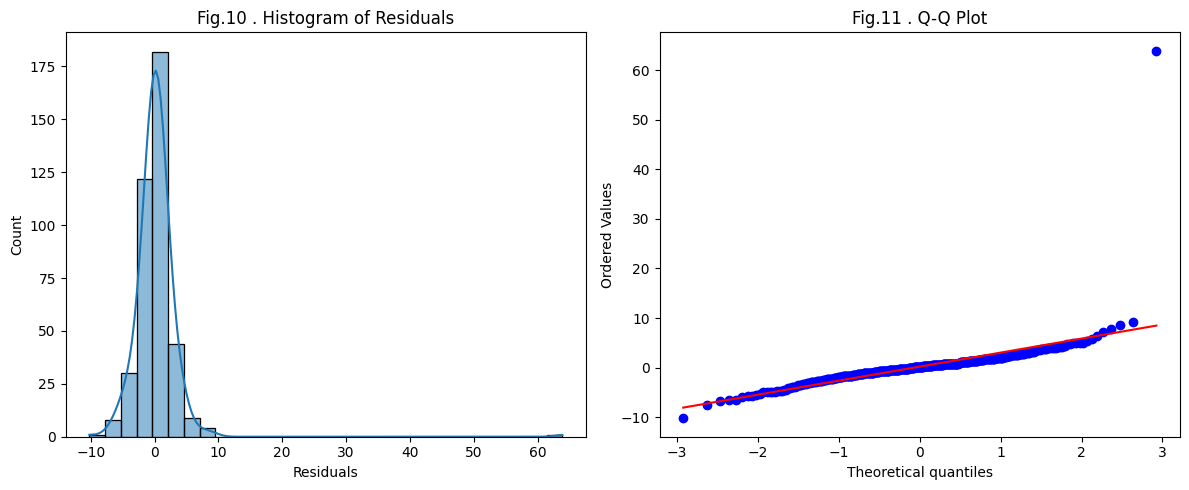

Shapiro-Wilk Test: W=0.5083, p-value=7.6163e-32


In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy import stats
import itertools

# Load dataset
file_path = 'D:/Statistics/ts2.csv'  # Replace with actual file path
data_raw = pd.read_csv(file_path)
data = data_raw.rename(columns={"Unnamed: 0": "Time", "x": "Value"}).set_index("Time")

# Fix index to DatetimeIndex
data.index = pd.date_range(start='2024-01-01', periods=len(data), freq='D')  # Adjust as needed
print("Index fixed to DatetimeIndex:", data.index)

# Step 1: Differencing (if needed)
diff_data = data.diff().dropna()

# Step 2: Plot ACF and PACF to identify ARIMA parameters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(diff_data, lags=20, ax=plt.gca())
plt.title('Fig.4. ACF Plot')
plt.subplot(1, 2, 2)
plot_pacf(diff_data, lags=20, ax=plt.gca())
plt.title('Fig.5 . PACF Plot')
plt.tight_layout()
plt.show()

# Step 3: Define a function for ARIMA grid search
def grid_search_arima(data, p_values, d_values, q_values):
    best_aic = float('inf')
    best_order = None
    best_model = None

    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = SARIMAX(data, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (p, d, q)
                best_model = results
        except Exception as e:
            continue
    return best_order, best_aic, best_model

# Step 4: Perform grid search to find optimal ARIMA parameters
p_values = range(0, 3)  # Adjust as needed
d_values = range(0, 1)  # Differencing order; typically 0 or 1
q_values = range(0, 3)  # Adjust as needed

best_order, best_aic, best_model = grid_search_arima(data['Value'], p_values, d_values, q_values)
print(f"Best ARIMA Order: {best_order}, AIC: {best_aic}")

# Step 5: Refit the model with best parameters
model = SARIMAX(data['Value'], order=best_order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

# Step 6: Forecasting
forecast_steps = 60  # Adjust the number of steps to forecast
forecast = results.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(data.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Plot forecast
forecast_ci = forecast.conf_int()
plt.figure(figsize=(12, 6))
plt.plot(data['Value'], label='Observed')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='orange')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='orange', alpha=0.2)
plt.title('Fig.6. ARIMA Model Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Step 7: Residual Diagnostics
residuals = results.resid

# Residual plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(residuals)
plt.title('Fig.7 . Residuals Over Time')
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Fig.8 . Histogram of Residuals')
plt.tight_layout()
plt.show()

# Residual statistics
print("Mean of residuals:", np.mean(residuals))
print("Variance of residuals:", np.var(residuals))

# Step 8: Calculate MSE and RMSE
# Ensure fitted values align with actual values by dropping NaNs
actual_values = data['Value'].iloc[1:]  # Skip the first value (due to differencing)
fitted_values = results.fittedvalues.iloc[1:]  # Align fitted values by skipping the first value

# Calculate MSE and RMSE
mse = mean_squared_error(actual_values, fitted_values)
rmse = np.sqrt(mse)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Step 9: Residual Histogram and Q-Q Plot
plt.figure(figsize=(12, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True, bins=30)
plt.title('Fig.10 . Histogram of Residuals')
plt.xlabel('Residuals')

# Q-Q Plot
plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Fig.11 . Q-Q Plot')

plt.tight_layout()
plt.show()

# Shapiro-Wilk test for residual normality
shapiro_test = stats.shapiro(residuals)
print(f'Shapiro-Wilk Test: W={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4e}')
